In [1]:
%pylab inline
import sklearn.feature_extraction.image
import sklearn.metrics
import theanets
import climate
import os
import pyprind
import datetime
#climate.enable_default_logging()
import glob
pylab.rcParams['figure.figsize'] = (15.0, 10.0)

Populating the interactive namespace from numpy and matplotlib


Using gpu device 0: GeForce GTX 770


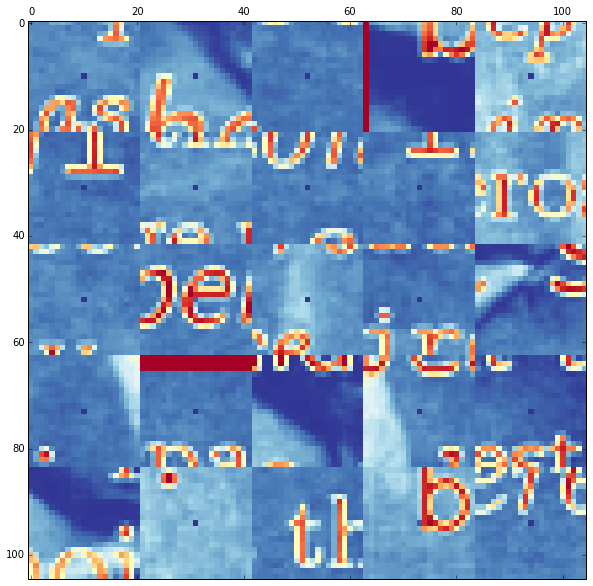

In [2]:
patch_size = 21
patch_center = patch_size / 2
max_patches = 1000
n_images = 20

all_images = [int(filter(char.isdigit, image)) for image in glob.glob("train/*.png")]
all_train_images = [i for i in all_images if i % 5]
all_valid_images = [i for i in all_images if not i % 5]

def enlargen_image(image):
    enlargened_size = (image.shape[0] + patch_center*2, image.shape[1] + patch_center*2)
    enlargened_image = np.ones(enlargened_size, dtype=np.float32)*-1
    enlargened_image[patch_center:-patch_center, patch_center:-patch_center] = image
    return enlargened_image

def batch(mode):
    if mode == 'train':
        images = np.random.choice(all_train_images, n_images)
    else:
        images = np.random.choice(all_valid_images, n_images)
        
    X_patches = np.zeros((0, patch_size, patch_size))
    y_patches = np.zeros((0, patch_size, patch_size))
    
    for image in images:
        X_image = imread('train/%d.png' % image)
        y_image = imread('train_cleaned/%d.png' % image)
        
        enlargened_X = enlargen_image(X_image)
        enlargened_y = enlargen_image(y_image)
        rand_seed = np.random.randint(0, 1000000)

        X_p = sklearn.feature_extraction.image.extract_patches_2d(
            enlargened_X, 
            (patch_size, patch_size), 
            max_patches=max_patches,
            random_state=rand_seed)
        X_patches = np.concatenate([X_patches, X_p])
        y_p = sklearn.feature_extraction.image.extract_patches_2d(
            enlargened_y,
            (patch_size, patch_size), 
            max_patches=max_patches,
            random_state=rand_seed)
        y_patches = np.concatenate([y_patches, y_p])
        
    y_cls = y_patches[:, patch_center, patch_center]
    X_patches = X_patches[:, :, :].astype(np.float32).reshape(X_patches.shape[0], patch_size**2)
    return X_patches, y_cls.astype(np.float32)[:, newaxis]

def train_batch():
    return batch('train')
def valid_batch():
    return batch('valid')
def view_batch():
    xs, ys = train_batch()
    choices = np.random.choice(xs.shape[0], 5)
    ximgs = xs[choices, :].reshape(5, patch_size, patch_size)
    ximgs[:, patch_size/2, patch_size/2] = ys.flatten()[choices]
    return np.concatenate(ximgs, axis=1)
matshow(np.concatenate([view_batch() for _ in range(5)]), cmap='RdYlBu')

In [3]:
import theano.tensor as T

def truncating_func(output):
        upper_trunc = T.switch(T.ge(output, 1), 1 + (output - 1) * 0.005, output)
        lower_trunc = T.switch(T.ge(0, upper_trunc), upper_trunc * 0.005, upper_trunc)
        return lower_trunc
    
class ClippingMSE(theanets.Loss):
    def __call__(self, outputs):
        output = truncating_func(outputs[self.output_name])
        target = self.input if self.target is None else self.target
        diff = output - target
        err = self.diff(outputs)
        if self.weight is not None:
            return (self.weight * err * err).sum() / self.weight.sum()
        return (err * err).mean()

In [4]:
exp = theanets.Regressor(
    loss='ClippingMSE',
    layers=(
        patch_size**2,
        (patch_size**2,  'relu'),
        (patch_size**2,  'relu'),
        (patch_size**2,  'relu'),
        1
    )
)
training_err = []
valid_err = []

2015-09-17 17:43:08.304069
Train	Valid	step
2015-09-17 17:44:50.531447	0.005112	0.001292	1
2015-09-17 17:45:45.643425	0.000855	0.001292	2
2015-09-17 17:46:40.915220	0.000736	0.001292	3
2015-09-17 17:48:21.507477	0.000679	0.000690	4
2015-09-17 17:49:15.896784	0.000647	0.000690	5
2015-09-17 17:50:11.072646	0.000667	0.000690	6
2015-09-17 17:51:53.722514	0.000619	0.000618	7
2015-09-17 17:52:50.975792	0.000604	0.000618	8
2015-09-17 17:53:46.833510	0.000639	0.000618	9
2015-09-17 17:55:29.072988	0.000577	0.000561	10
2015-09-17 17:56:23.579695	0.000583	0.000561	11
2015-09-17 17:57:17.813309	0.000566	0.000561	12
2015-09-17 17:58:57.703550	0.000570	0.000768	13
2015-09-17 17:59:53.440094	0.000546	0.000768	14


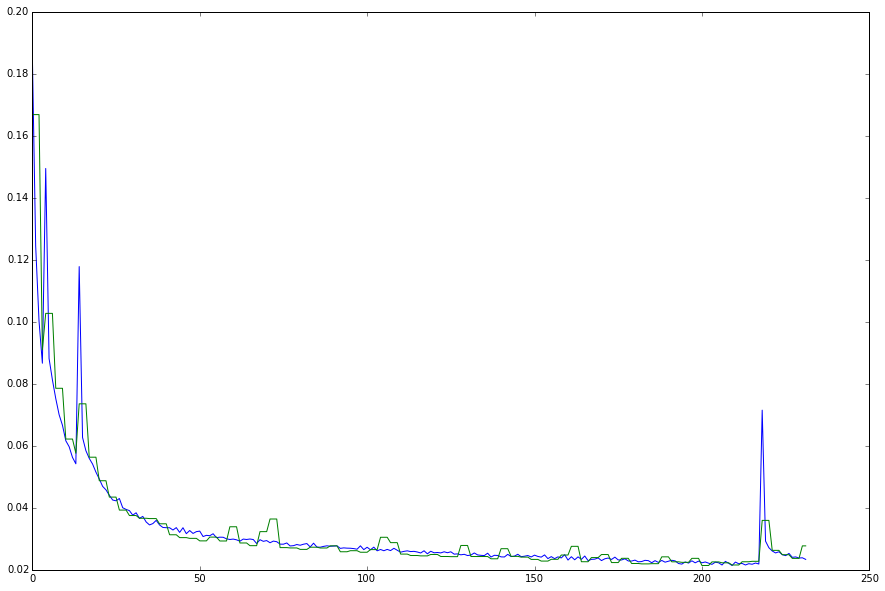

In [20]:
# We do one fake round of training to deal with the initial 
# crazyness.
exp.itertrain(
    train_batch,
    valid_batch,
    algorithm='adam',
    validate_every=3,
    visible_dropout=0.5,
    hidden_dropout=0.25).next()
print datetime.datetime.now()
print("Train\tValid\tstep")
i = 0
for train, valid in exp.itertrain(
    train_batch,
    valid_batch,
    algorithm='adam',
    validate_every=3,
    visible_dropout=0.5,
    hidden_dropout=0.25):
    if i > 2500:
        break
    else:
        i += 1
    print "%s\t%03f\t%03f\t%d" % (datetime.datetime.now(), train['loss'], valid['loss'], i)
    training_err.append(train['loss']**0.5)
    valid_err.append(valid['loss']**0.5)
plot(training_err)
plot(valid_err)

In [17]:
#exp.save('current_theanet_network.pkl')

In [18]:
def apply_model(image, exp):
    patches = sklearn.feature_extraction.image.extract_patches_2d(image, (patch_size, patch_size))
    patches_flat = patches.reshape(patches.shape[0], patches.shape[1]*patches.shape[2])
    denoised_values = exp.predict(patches_flat).flatten()
    #return denoised_values 
    return clip(denoised_values, 0, 1)

0.0306060471888


<matplotlib.colorbar.Colorbar instance at 0x7f269f509320>

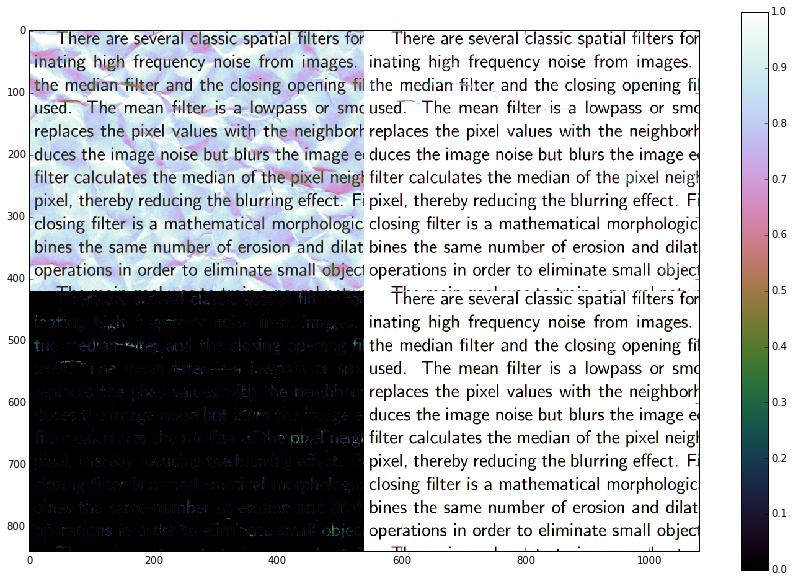

In [19]:
actual = imread('train/120.png').astype(np.float32)
cleaned = imread('train_cleaned/120.png').astype(np.float32)

image = enlargen_image(actual)
denoised = apply_model(image, exp)
pred = denoised.reshape((image.shape[0]-patch_size+1, image.shape[1]-patch_size+1))

diff = np.abs(cleaned - pred)

import sklearn.metrics
print sklearn.metrics.mean_squared_error(cleaned, pred)**0.5

imshow(
    np.clip(np.concatenate([
        np.concatenate([actual, pred], axis=1),
        np.concatenate([diff, cleaned], axis=1)
    ]), -1, 2), cmap='cubehelix', interpolation='none')
plt.colorbar()

<matplotlib.colorbar.Colorbar instance at 0x7fd7839c4ea8>

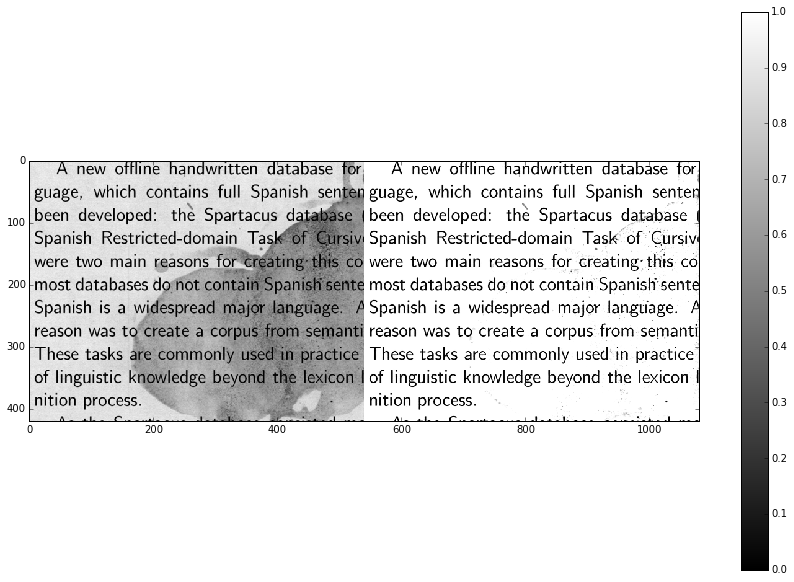

In [15]:
filename = 'test/109.png'
image = imread(filename)

actual = imread(filename).astype(np.float32)
image = enlargen_image(actual)
denoised = apply_model(image, exp)
pred = denoised.reshape(actual.shape)

imshow(np.concatenate([actual, pred], axis=1), cmap='gray', interpolation='none')
plt.colorbar()

In [14]:
def calculate_err(image_set, note):
    mses = []
    squared_error = 0
    n = 0

    for imname in pyprind.prog_bar(image_set):
        x = imread('train/%d.png' % imname)
        image = enlargen_image(x)
        cleaned = imread('train_cleaned/%d.png' % imname)
        denoised = apply_model(image, exp)
        pred = denoised.reshape(x.shape)

        squared_error += np.sum((pred - cleaned)**2)**0.5
        n += cleaned.size
        mse = sklearn.metrics.mean_squared_error(cleaned, pred)**0.5
        mses.append(mse)
    print "MSE for %s examples is %f" % (note, squared_error / n)
    print "Average of MSE for %s examples is %f" % (note, np.mean(mses))

calculate_err(all_valid_images, "VALIDATION")
calculate_err(all_train_images, "TRAINING")

0%                         100%
[#############################] | ETA[sec]: 0.000 
Total time elapsed: 36.966 sec
0%                          100%
[##############################] | ETA[sec]: 0.000 

MSE for VALIDATION examples is 0.000052
Average of MSE for VALIDATION examples is 0.023445
MSE for TRAINING examples is 0.000052
Average of MSE for TRAINING examples is 0.023509



Total time elapsed: 144.745 sec


# TODO

- submission
- loss function improvements
- parameter search
- deep highways and deeper nets
- more patience
- better edge detection (ie, not just a blacked out zone)

In [16]:
entries = []
for directory, subdirs, files in os.walk('test'):
    for image in pyprind.prog_bar([f for f in files if f.endswith('.png')]):
        image_number = int(''.join([n for n in image if n.isdigit()]))
        X_image = imread(os.path.join(directory, image))
        enlarged_size = (X_image.shape[0] + patch_center*2, X_image.shape[1] + patch_center*2)
        enlargened_X = np.zeros(enlarged_size, dtype='float32')
        enlargened_X[patch_center:-patch_center, patch_center:-patch_center] = X_image
        pred = apply_model(enlargened_X, exp).reshape(X_image.shape)
        imsave(os.path.join('denoised', image), pred, cmap='cubehelix')
        for row in range(pred.shape[0]):
            for col in range(pred.shape[1]):
                entries.append(("%d_%d_%d" % (image_number, row+1, col+1), pred[row, col]))

0%                          100%
[##############################] | ETA[sec]: 0.000 
Total time elapsed: 115.990 sec


In [17]:
import csv
import gzip
with gzip.open('submission.csv.gz', 'w', 9) as subfile:
    writer = csv.writer(subfile)
    writer.writerow(('id', 'value'))
    writer.writerows(entries)